In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pylab 
import itertools
from UCB_discrete import Environment
from UCB_discrete import UCB_os_gau, UCB_os_exp
from collections import defaultdict

%matplotlib inline

# UCB for order statistics

This notebook is designed to show the idea using order statistics to design UCB policies works empirically. The experiment is designed on simulated data, for two special reward distributions proved by [notes](https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat): 

(1) Absolute value of center Gaussian rewards  
(2) Exponential rewards

For each case, we show the results for both estiamted parameter and true parameter.

Settings: 3 independent arms, 10000 rounds with 50 indepenent experiments. Evaluated by 
a. expected cumulative regret  
b.the percent of best arm selected. 

Policy (Empirical policy): In round t+1, select the arm with index, 
$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \beta(\sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)})$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = \alpha \log t$, $v_t$ depends on reward distributions. $T_i(t)$ is the number of times arm i has been played until round t. 

We fix the parameters $\alpha, \beta$ in this notebook, see [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/ucb_os_hyperparameter_tuning_outliers_testing.ipynb) for experiments on tuning parameters, [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/Variance_Sensitiveness_test.ipynb) for experiments test the policy senstivity for different variance of reward distribution, [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/Sanity_test.ipynb) for some sanity test of our policy.  

In [ ]:
# setting

num_rounds = 5000
num_exper = 50
num_arms = 3

# parameter for policy

alpha = 0.2
beta = 0.5

### Absolute value of center Gaussian rewards  

parameter $\sigma_i = [0.1, 0.2, 0.3]$

In [3]:
rewards_env = []
medians = []
num_sample = 10000

for i in range(num_arms):
    # rewards distribution of arms is gaussian distribution with 
    # mean as 0, variance as i.
    rewards_env.append(Environment(loc = 0, scale = (i + 1) * 0.1))
    medians.append(np.median(Environment(loc = 0, scale = (i + 1) * 0.1, size = num_sample).sample()))
    
best_arm = np.argmax(medians)
print('medians are: ', medians)
print('best arm is ', best_arm)

medians are:  [0.06735449903965375, 0.134940342334057, 0.20222876085555613]
best arm is  2


In [5]:
# use estimate variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = True, alpha = alpha, beta = beta)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_est_var_gau = np.mean(regrets, axis = 0)

In [6]:
# use true variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = False, alpha = alpha, beta = beta)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_gau = np.mean(regrets, axis = 0)

In [7]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        delta = medians[best_arm] - medians[i]
        sigma = (i + 1) * 0.1
        beta = 32 * np.log(num_round) * sigma * (2 * sigma + delta * np.sqrt(2 * np.log(2)))
        if i != best_arm:
            bound += (np.sqrt(beta) + 8 * sigma * np.sqrt(np.log(num_round))) ** 2 /(np.log(2) * delta**2) 
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

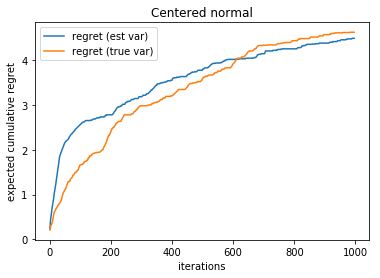

In [9]:
#plt.plot(np.asarray(bounds), label = 'bound')
plt.plot(expected_regrets_est_var_gau, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_gau, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Centered normal')
plt.legend()
#plt.savefig('ucb_orderstat_centered_normal.png')

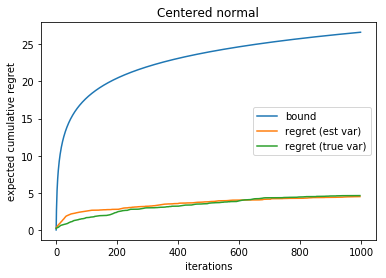

In [14]:
# the bound seems too big, divided by 1000, replot

plt.plot(np.asarray(bounds)/1000, label = 'bound')
plt.plot(expected_regrets_est_var_gau, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_gau, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Centered normal')
plt.legend()
# plt.savefig('ucb_orderstat_centered_normal.png')

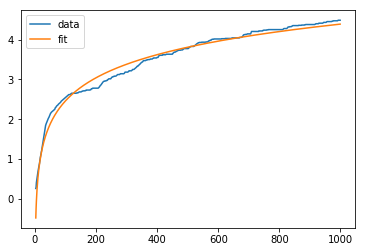

In [11]:
# fit log curve 

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

xdata = range(3, num_rounds)
popt, pcov = curve_fit(func, xdata, expected_regrets_est_var_gau)
plt.plot (xdata, expected_regrets_est_var_gau, label = 'data')
plt.plot(xdata, func(xdata, *popt), label = 'fit')
plt.legend()

### For Exponentional Random Variables:

In [15]:
class Exp_Environment():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None):  
        self.scale = scale
        self.size = size
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        return np.random.exponential(self.scale, self.size)

In [129]:
# setting 

num_rounds = 10000
num_exper = 10
num_arms = 3
# scales = [1, 2, 2.0/3] # lambda = 1, 0.5, 1.5
scales = [2.5, 2, 5.0/3] # lambda = 0.4, 0.5, 0.6


alpha = 2
beta = 0.5

rewards_env = []
medians = []

num_samples = 100000

for i in range(num_arms):
    rewards_env.append(Exp_Environment(scale = scales[i]))
    medians.append(np.median(np.random.exponential(scale = scales[i], size = num_samples)))
    
print('medians are: ', medians)

best_arm = np.argmax(medians)

medians are:  [1.741834745667765, 1.396114232971406, 1.164963758039495]


In [130]:
%%capture

# use estimate variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = True, alpha = alpha, beta = beta)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_est_var_exp = np.mean(regrets, axis = 0)

In [131]:
%%capture

# use true variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = False, alpha = alpha, beta = beta)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp = np.mean(regrets, axis = 0)

In [132]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        theta = 1.0/scales[i]
        delta = medians[best_arm] - medians[i]
        beta = 32 * np.log(num_round) * (1 + delta * theta)
        if i != best_arm:
            bound += (np.sqrt(beta) + 4 * np.sqrt(2 * np.log(num_round)))**2/ (delta**2 * theta ** 2)
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

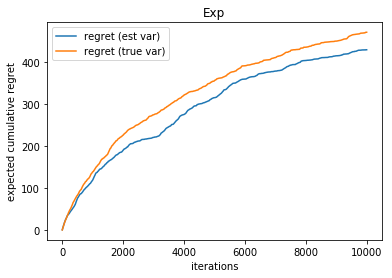

In [133]:
#plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_est_var_exp, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_exp, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()
#plt.savefig('ucb_orderstat_exp_estimate_variance.png')

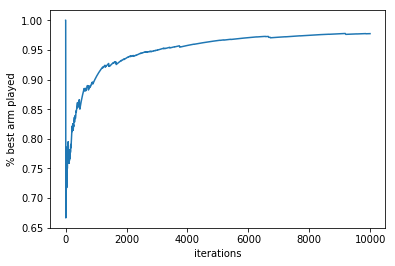

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


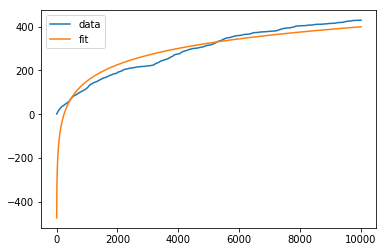

In [134]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

xdata = range(3, num_rounds)
popt, pcov = curve_fit(func, xdata, expected_regrets_est_var_exp)
plt.plot (xdata, expected_regrets_est_var_exp, label = 'data')
plt.plot(xdata, func(xdata, *popt), label = 'fit')
plt.legend()

In [52]:
import pickle 
saving = {}
saving['normal_est'] = expected_regrets_est_var
saving['normal_true'] = expected_regrets_true_var
saving['exp_est'] = expected_regrets_est_var_exp
saving['exp_true'] = expected_regrets_true_var_exp

#with open('os_saving.pickle', 'wb') as handle:
#    pickle.dump(saving, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
#with open('os_saving.pickle', 'rb') as handle:
#    b = pickle.load(handle)


### Results log

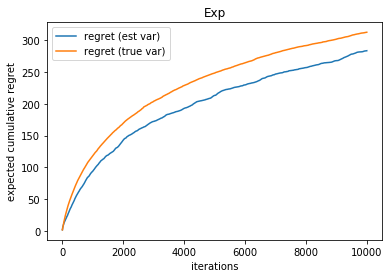

In [98]:
# alpha = 2, beta = 1

#plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_est_var_exp, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_exp, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()
#plt.savefig('ucb_orderstat_exp_estimate_variance.png')

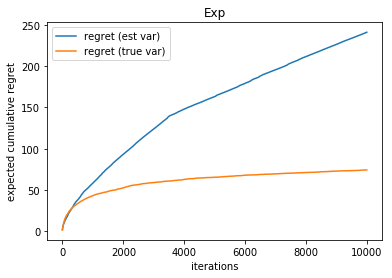

In [106]:
alpha = 1
beta = 0.5

#plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_est_var_exp, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_exp, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()
#plt.savefig('ucb_orderstat_exp_estimate_variance.png')

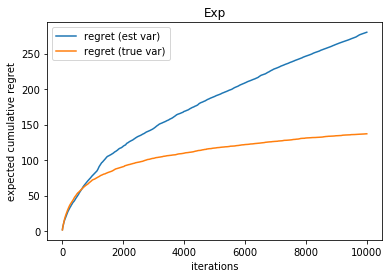

In [123]:
# alpha = 2 beta = 0.5

#plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_est_var_exp, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_exp, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()